## MNIST Data

In [ ]:
using MLDatasets
using Plots
using Images
using StatsBase
using BSON, JSON
using Flux
using Flux: onecold
using Random
using Printf
using ProgressMeter

In [ ]:
using Revise
using DenoisingDiffusion 
using DenoisingDiffusion: train!, split_validation

In [ ]:
include("../common/utilities.jl");
include("../common/reporting.jl");
include("../common/gaussian_fretchet_distance.jl");

## Load

In [ ]:
data_directory="C:\\Users\\sinai\\Documents\\Projects\\datasets\\MNIST"
trainset = MNIST(Float32, :train, dir=data_directory)
testset = MNIST(Float32, :test, dir=data_directory)

display(trainset)
display(testset)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [ ]:
for pair in trainset.metadata
    println(pair[1], " => ", pair[2])
end

n_observations => 60000
targets_path => C:\Users\sinai\Documents\Projects\datasets\MNIST\train-labels-idx1-ubyte.gz
features_path => C:\Users\sinai\Documents\Projects\datasets\MNIST\train-images-idx3-ubyte.gz


In [ ]:
trainset = MNIST(Float32, :train, dir=data_directory);
norm_data = normalize_neg_one_to_one(reshape(trainset.features, 28, 28, 1, :));
labels = 2 .+ trainset.targets; # 1->default, 2->0, 3->1, ..
train_x, val_x = split_validation(MersenneTwister(2714), norm_data, labels);

## Test

### load model

In [ ]:
directory = "../models/MNIST_20221219_16cond_400k"
diffusion_path = joinpath(directory, "model_epoch=20.bson");
history_path = joinpath(directory, "history.json");

In [ ]:
diffusion = BSON.load(diffusion_path)[:model]
println("data shape:    $(diffusion.data_shape)")
num_timesteps = diffusion.num_timesteps
println("num timesteps: $(num_timesteps)")
diffusion.denoise_fn

data shape:    (28, 28, 1)
num timesteps: 100


UNetConditioned(
  time_embedding = Chain(
    SinusoidalPositionEmbedding(100 => 64),
    Dense(64 => 64, gelu),              # 4_160 parameters
    Dense(64 => 64),                    # 4_160 parameters
  ),
  class_embedding = Embedding(11 => 64),  # 704 parameters
  combine_embeddings = vcat,
  chain = ConditionalChain(
    init = Conv((3, 3), 1 => 16, pad=1),  # 160 parameters
    down_1 = ResBlock(
      in_layers = ConvEmbed(
        embed_layers = Chain(
          NNlib.swish,
          Dense(128 => 16),             # 2_064 parameters
        ),
        conv = Conv((3, 3), 16 => 16, pad=1),  # 2_320 parameters
        norm = GroupNorm(16, 8),        # 32 parameters
        activation = NNlib.swish,
      ),
      out_layers = Chain(
        Conv((3, 3), 16 => 16, pad=1),  # 2_320 parameters
        GroupNorm(16, 8),               # 32 parameters
        NNlib.swish,
      ),
      skip_transform = identity,
    ),
    skip_1 = ConditionalSkipConnection(
      ConditionalChain(


In [ ]:
history = JSON.parsefile(history_path)

Dict{String, Any} with 3 entries:
  "epoch_size"      => 54000
  "mean_batch_loss" => Any[0.250401, 0.0706438, 0.0610643, 0.0546075, 0.0499745…
  "val_loss"        => Any[0.0827505, 0.0643162, 0.0582642, 0.0512311, 0.047873…

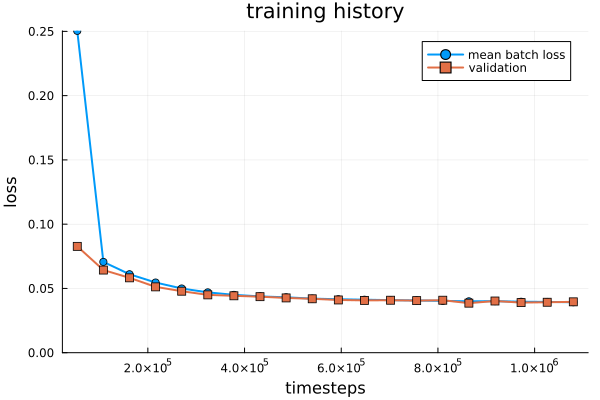

In [ ]:
timesteps = (1:length(history["mean_batch_loss"])) * history["epoch_size"]

p = plot(timesteps, history["mean_batch_loss"], 
    label="mean batch loss", ylims=(0, Inf),
    title="training history",
    xlabel="timesteps",
    ylabel="loss",
    linewidth=2,
    markershape=:circle,
)
plot!(p, timesteps, history["val_loss"], label="validation", linewidth=2, markershape=:square)
savefig(p, joinpath(directory, "loss.png"))
p

### validate

In [ ]:
val_loss = 0.0
val_data = Flux.DataLoader(val_x[1]; batchsize=32, shuffle=false);
#val_data = Flux.DataLoader(val_x; batchsize=32, shuffle=false);
@showprogress for x in val_data
    global val_loss
    val_loss += p_losses(diffusion, Flux.mse, x; to_device=cpu)
    #val_loss += p_losses(diffusion, Flux.mse, xy; to_device=cpu, p_uncond=0.2)
end
val_loss /= length(val_data)
@printf("\nval loss: %.5f\n", val_loss)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:32m



val loss: 0.03995


### sample

In [ ]:
X0s =  Array{Float32}(undef,  diffusion.data_shape..., 0)
scales = [1.0f0, 1.5f0, 2.0f0, 3.0f0, 5.0f0, 10.0f0]
for scale in scales
    X0  = p_sample_loop(diffusion, 1, 2 + 4; to_device=cpu, guidance_scale=scale);
    global X0s = cat(X0s, X0, dims=4)
end

Sampling ... 100%|███████████████████████████████████████| Time: 0:00:02
Sampling ... 100%|███████████████████████████████████████| Time: 0:00:03
Sampling ... 100%|███████████████████████████████████████| Time: 0:00:02
Sampling ... 100%|███████████████████████████████████████| Time: 0:00:02
Sampling ... 100%|███████████████████████████████████████| Time: 0:00:02
Sampling ... 100%|███████████████████████████████████████| Time: 0:00:02


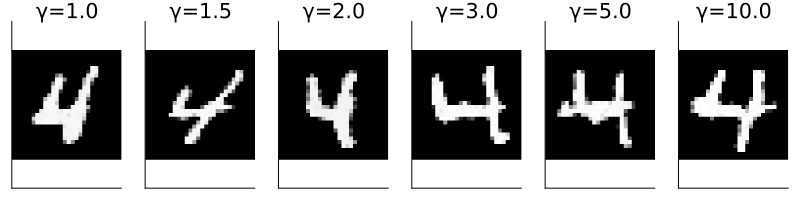

In [ ]:
imgs = convert2image(trainset, X0s[:, :, 1, :]);
canvas_scales = plot([plot(imgs[:, :, i], title="γ=$(scales[i])") for i in 1:length(scales)]..., 
    layout=(1, length(scales)), 
    ticks=nothing,
    size=(800, 200)
)
savefig(canvas_scales, joinpath(directory, "samples_guidance.png"))
canvas_scales

In [ ]:
Xs, X0s = p_sample_loop_all(diffusion, collect(2:11); guidance_scale=2.0f0, to_device=cpu);

Sampling... 100%|████████████████████████████████████████| Time: 0:00:25


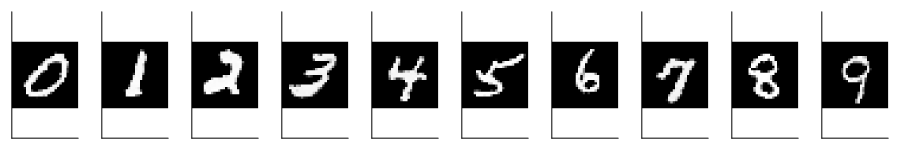

In [ ]:
imgs = convert2image(trainset, Xs[:, :, 1, :, end]);
canvas_samples = plot([plot(imgs[:, :, i]) for i in 1:10]..., 
    layout=(1, 10), 
    ticks=nothing,
    size=(900, 150)
)
savefig(canvas_samples, joinpath(directory, "samples.png"))
canvas_samples

## Animations

In [ ]:
function combine(imgs::AbstractArray, nrows::Int, ncols::Int, border::Int)
    canvas = zeros(Gray, 28 * nrows + (nrows+1) * border, 28 * ncols + (ncols+1) * border)
    for i in 1:nrows
        for j in 1:ncols
            left = 28 * (i-1) + 1 + border * i 
            right = 28 * i + border * i
            top = 28 * (j - 1) + 1 + border * j
            bottom = 28 * j + border * j
            canvas[left:right, top:bottom] = imgs[:, :, ncols * (i-1) + j]
        end
    end
    canvas
end

combine (generic function with 1 method)

In [ ]:
anim_denoise = @animate for i ∈ 1:(num_timesteps + 15)
    i = i > num_timesteps ? num_timesteps : i
    imgs = convert2image(trainset, Xs[:, :, 1, :, i]);
    imgs_ests = convert2image(trainset, X0s[:, :, 1, :, i]);
    canvas = combine(imgs, 1, 10, 2)
    canvas_est = combine(imgs_ests, 1, 10, 2)
    p1 = plot(canvas, ticks=nothing )
    p2 = plot(canvas_est, ticks=nothing)
    plot(p1, p2, layout=(2, 1), plot_title="i=$i", size=(900, 270))
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_VS3HVK", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000106.png", "000107.png", "000108.png", "000109.png", "000110.png", "000111.png", "000112.png", "000113.png", "000114.png", "000115.png"])

[ Info: Saved animation to C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\models\MNIST_20221219_16cond_400k\reverse_numbers.gif


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion-examples\\models\\MNIST_20221219_16cond_400k\\reverse_numbers.gif")
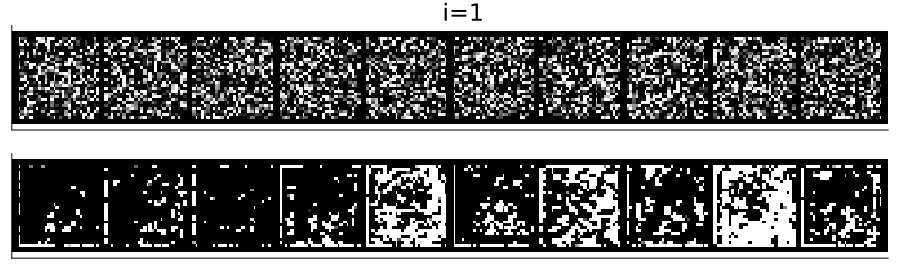

In [ ]:
gif(anim_denoise, joinpath(directory, "reverse_numbers.gif"), fps=15)

closest samples

## Compare to ground truth data

idx=6
max difference: 0.0186
min difference: 0.0069
label of closest: 5


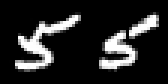

idx=8
max difference: 0.0184
min difference: 0.0055
label of closest: 7


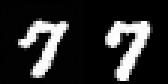

idx=9
max difference: 0.0181
min difference: 0.0064
label of closest: 8


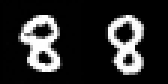

idx=3
max difference: 0.0189
min difference: 0.0062
label of closest: 2


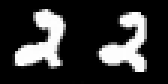

In [ ]:
for idx in sample(1:size(X0s, 4), 4, replace=false)
    x = normalize_zero_to_one(X0s[:, :, :, idx, end]);
    min_difference = Inf
    max_difference = 0.0
    closest = 1
    for i in 1:length(trainset)
        difference = sqrt(sum(abs2, x -trainset.features[:, :, i])) / length(x)
        if difference < min_difference
            closest = i
            min_difference = difference
        end
        max_difference = max(max_difference, difference)
    end
    println("idx=$idx")
    @printf("max difference: %6.4f\n", max_difference)
    @printf("min difference: %6.4f\n", min_difference)
    @printf("label of closest: %d\n", trainset.targets[closest])
    img_x =  convert2image(trainset, x[:, :, 1]);
    img_closest = convert2image(trainset, trainset.features[:, :, closest])
    display([img_x img_closest])
end

## Frechet LeNet Distance

### 1) model

In [ ]:
classifier_path = "..\\models\\LeNet5\\model.bson"

"..\\models\\LeNet5\\model.bson"

In [ ]:
classifier = BSON.load(classifier_path)[:model]
classifier_headless = classifier[1:(end - 1)]
println("classifier_headless = " * repr("text/plain", classifier_headless) * "\n")
head = classifier[end]
println("head = " * repr("text/plain", head))

classifier_headless = Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
)                   # Total: 8 arrays, 43_576 parameters, 171.422 KiB.

head = Dense(84 => 10)     # 850 parameters


In [ ]:
accuracy(ŷ, y) = mean(onecold(ŷ, 0:9) .== onecold(y, 0:9))

accuracy (generic function with 1 method)

In [ ]:
X_test = reshape(testset.features, 28, 28, 1, :)
ŷ = classifier(X_test)
mean(onecold(ŷ, :0:9) .== testset.targets)

0.9891

### 2 ) data

In [ ]:
generate_data = false;

In [ ]:
if generate_data
    out_path = joinpath(directory, "generatedset.bson")
    to_device = gpu
    T = eltype(eltype(diffusion))
    x_out = Array{T}(undef,  diffusion.data_shape..., 0)
    labels = Vector{Int}()
    diffusion = diffusion |> to_device

    start_time = time_ns()
    batch_size = 100
    for i in 2:11
        global x_out
        println(stderr, i)
        X0 = p_sample_loop(diffusion, batch_size, i; to_device=to_device, guidance_scale=2.0f0)
        X0 = cpu(X0)
        x_out = cat(x_out, X0, dims=4)
        labels = vcat(labels, fill(i, batch_size))
        BSON.bson(out_path, Dict(:generatedset=>x_out, :labels=>labels))
    end
    end_time = time_ns() - start_time
    println("\ndone generation")
    @printf "time taken: %.2fs\n" end_time / 1e9

    BSON.bson(out_path, Dict(:generatedset=>x_out, :labels=>labels))

    diffusion = diffusion |> cpu ;
end

In [ ]:
## load
generated_path = joinpath(directory, "generatedset_guidance=2.bson");
generated_data = BSON.load(generated_path)
y_generated = generated_data[:labels] ;
X_generated = generated_data[:generatedset];

In [ ]:
n_samples = min(size(X_generated, 4), length(testset))
println("n_samples: ", n_samples)
rng = MersenneTwister(314159)
idxs = randperm(rng, length(trainset))[1:n_samples]

X_train = trainset.features[:, :, idxs];
X_train = reshape(X_train, 28, 28, 1, :);

idxs = randperm(rng, length(testset))[1:n_samples]
X_test = testset.features[:, :, idxs];
y_test = testset.targets[idxs]
X_test = reshape(X_test, 28, 28, 1, :);

X_rand = randn(Float32, 28, 28, 1, n_samples);
clamp!(X_rand, -1, 1);

X_generated = X_generated[:, :, :, 1:n_samples] ;
y_generated = y_generated[1:n_samples] ;

n_samples: 10000


In [ ]:
for i in 1:n_samples
    global X_generated
    X_generated[:, :, :, i] = normalize_zero_to_one(X_generated[:, :, :, i])
end
for i in 1:n_samples
    global X_rand
    X_rand[:, :, :, i] = normalize_zero_to_one(X_rand[:, :, :, i])
end

### 3) Statistics

In [ ]:
stats = Dict(
    :test => Dict{Symbol, Any}(),
    :train => Dict{Symbol, Any}(),
    :random => Dict{Symbol, Any}(),
    :generated => Dict{Symbol, Any}(),
);

In [ ]:
activations = Dict()
@time activations[:test] = classifier_headless(X_test);
println(size(activations[:test]))
@time activations[:train] = classifier_headless(X_train);
@time activations[:random] = classifier_headless(X_rand);
@time activations[:generated] = classifier_headless(X_generated);

  0.633483 seconds (11.18 k allocations: 400.764 MiB, 7.73% gc time, 2.38% compilation time)
(84, 10000)
  1.517613 seconds (364 allocations: 400.206 MiB, 5.42% gc time)
  1.168162 seconds (240 allocations: 400.196 MiB)
  0.795611 seconds (364 allocations: 400.206 MiB, 12.66% gc time)


 $$ FLD = ||\mu_1 - \mu_2||^2 + tr\left(\Sigma_1 + \Sigma_2 - 2\sqrt{\Sigma_1\Sigma_2}\right) $$

In [ ]:
μ_test = mean(activations[:test]; dims=2)
Σ_test = cov(activations[:test]; dims=2, corrected=true)
for dataset in [:test, :train, :random, :generated]
    println(stderr, dataset)
    μ = mean(activations[dataset]; dims=2)
    Σ = cov(activations[dataset]; dims=2, corrected=true)
    fld = gaussian_frechet_distance(μ_test, Σ_test, μ, Σ)
    stats[dataset][:μ] = μ
    stats[dataset][:Σ] = Σ
    stats[dataset][:fld] = fld
end

test
train
random
generated
┌ Warning: sqrt(Σ1 * Σ2) is complex
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\gaussian_fretchet_distance.jl:15
[ Info: imaginary components are small and have been set to zero


In [ ]:
@printf("FLD self:      %8.4f\n", stats[:test][:fld])
@printf("FLD train:     %8.4f\n", stats[:train][:fld])
@printf("FLD generated: %8.4f\n", stats[:generated][:fld])
@printf("FLD random:    %8.4f\n", stats[:random][:fld])

FLD self:       -0.0020
FLD train:       0.6268
FLD generated:   6.0419
FLD random:    400.1473


### 4)  classifier predictions

In [ ]:
for dataset in [:test, :train, :random, :generated]
    logits = head(activations[dataset])
    probs = sigmoid(logits)
    y = onecold(logits, 0:9)
    stats[dataset][:y] = y
    stats[dataset][:counts] = [count(x->x==label, y ) for label in 0:9]
    stats[dataset][:probs] = probs
    stats[dataset][:probs_y] = vec(maximum(probs, dims=1))
end

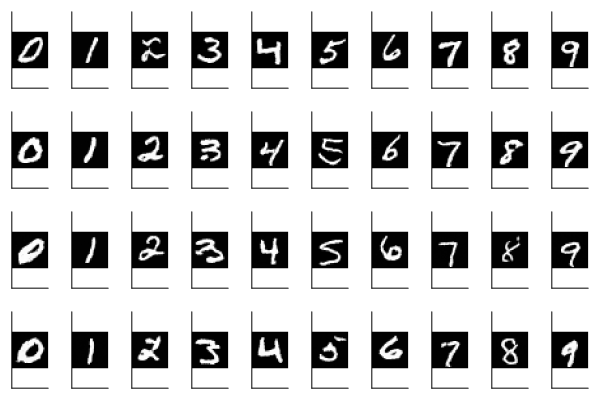

In [ ]:
nrows = 4
canvases = []
targets = stats[:generated][:y]
for label in 0:9
    idxs = (1:size(X_generated, 4))[targets .== label]
    for idx in rand(idxs, nrows)
        img = convert2image(trainset, X_generated[:, :, 1, idx])
        push!(canvases, plot(img))
    end
end
canvases = [canvases[nrows * j + i] for i in 1:nrows for j in 0:9]

plot(canvases..., layout=(nrows, 10), ticks=nothing)

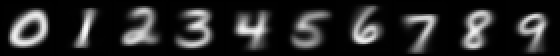

In [ ]:
mean_imgs_gen = []
for label in 0:9
    idxs = stats[:generated][:y] .== label
    x_mean = mean(X_generated[:, :, 1, idxs], dims=3)
    mean_img = convert2image(trainset, x_mean)
    push!(mean_imgs_gen, mean_img)
end
cat(mean_imgs_gen..., dims=2)[:, :, 1]

In [ ]:
cm = confusion_matrix(stats[:generated][:y], y_generated .- 2, 0:9)

10×10 Matrix{Int64}:
 993    0    7    0    0    0    0    0    0    0
   0  999    1    0    0    0    0    0    0    0
   0    1  995    1    1    0    1    0    1    0
   1    2    5  963    0   27    0    0    0    2
   0    0    0    0  999    0    1    0    0    0
   0    0    0    0    0  993    3    0    4    0
   1    0    0    0    0    0  999    0    0    0
   0    0    5    1    0    1    0  991    0    2
   0    0    1    0    0   15    2    1  981    0
   0    0    0    0   12    0    0    2    0  986

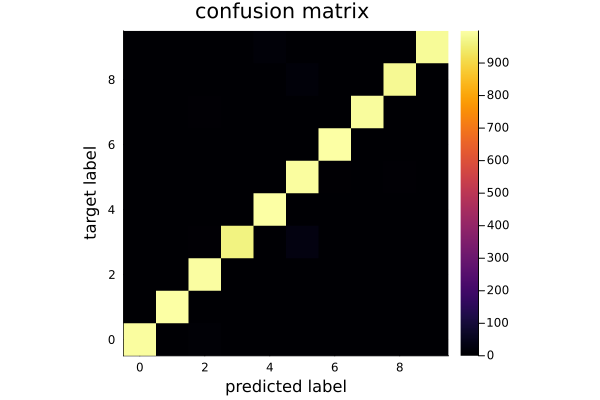

In [ ]:
canvas_cm = heatmap(0:9, 0:9, cm, xlabel="predicted label", ylabel="target label", xlims=(-0.5,9.5), aspectratio=1, 
    title="confusion matrix ")
savefig(canvas_cm, joinpath(directory, "confusion_matrix.png"))
canvas_cm

In [ ]:
classification_report(cm, 0:9)

              precision  recall  f1-score  support
           0       1.00    0.99      1.00     1000
           1       1.00    1.00      1.00     1000
           2       0.98    0.99      0.99     1000
           3       1.00    0.96      0.98     1000
           4       0.99    1.00      0.99     1000
           5       0.96    0.99      0.98     1000
           6       0.99    1.00      1.00     1000
           7       1.00    0.99      0.99     1000
           8       0.99    0.98      0.99     1000
           9       1.00    0.99      0.99     1000

weighted avg       0.99    0.99      0.99    10000

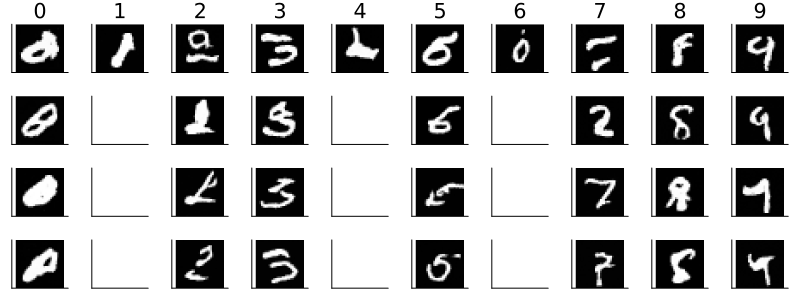

In [ ]:
wrong_idxs = collect(1:length(y_generated))[stats[:generated][:y] .!= y_generated .- 2];
n_rows = 4
idxs_to_plot = zeros(Int, (n_rows, 10))
# collect data by columns
for j in 0:9
    #j_idxs = wrong_idxs[stats[:generated][:y][wrong_idxs] .== j]  # plot by incorrect labels
    j_idxs = wrong_idxs[(y_generated[wrong_idxs] .-2) .== j] # plot by target labels
    sample_idxs = length(j_idxs) > n_rows ? sample(j_idxs, n_rows, replace=false) : j_idxs
    for (i, idx) in enumerate(sample_idxs)
        idxs_to_plot[i, j + 1] = idx
    end
end
canvases = []
# enter data into canvases by row
for i in 1:n_rows
    for j in 0:9
        idx = idxs_to_plot[i, j + 1]
        img = idx == 0 ? plot() : plot(convert2image(trainset, X_generated[:, :, 1, idx]))
        if i == 1 
            plot!(img, title=string(j))
        end
        push!(canvases, img)
    end
end
plot(canvases..., layout=(n_rows, 10), ticks=nothing, border=nothing,  size=(800, 300))

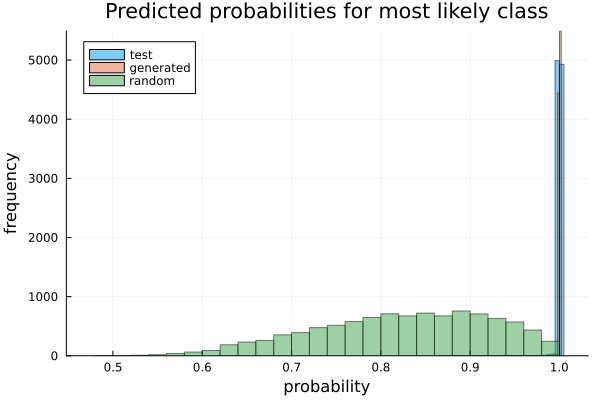

In [ ]:
nbins = 30
histogram(stats[:test][:probs_y], bins=nbins, alpha=0.5, label="test")
histogram!(stats[:generated][:probs_y], bins=nbins, alpha=0.5, label="generated")
histogram!(stats[:random][:probs_y], bins=nbins, alpha=0.5, label="random")
p = plot!(legend=:topleft, ylabel="frequency", xlabel="probability", title="Predicted probabilities for most likely class")
savefig(p, joinpath(directory, "LeNet_probabilities.png"))
p

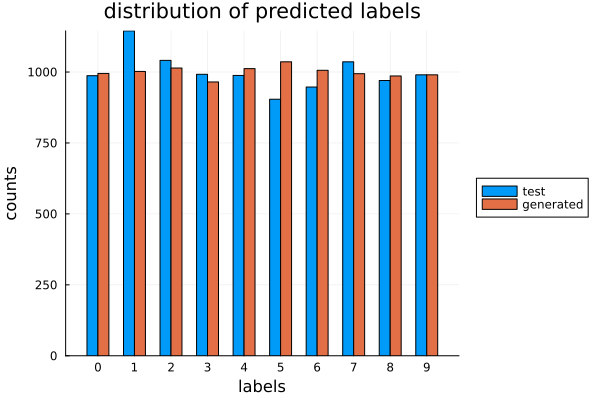

In [ ]:
width = 0.3
x1  = (1-width/2):1:(10-width/2)
x2  = (1+width/2):1:(10+width/2)
bar(x1, stats[:test][:counts], bar_width=width, label="test")
bar!(x2, stats[:generated][:counts], bar_width=width, label="generated")
p = plot!(
    ylabel="counts", xlabel="labels", xticks=(1:10, 0:9),
    title="distribution of predicted labels",
    legend=:outerright
)
savefig(p, joinpath(directory, "LeNet_label_counts.png"))
p